In [1]:
!pip install 'liac-arff>=2.4.0'

In [2]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index).tail(),
           train_X.tail()], axis=1)

,y,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,0,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,...,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,...,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,1,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,...,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,...,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,1,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,...,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


In [3]:
from sklearn.preprocessing import Normalizer as Norm
from lale.lib.lale import NoOp
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from lale.operators import make_pipeline
lale.wrap_imported_operators()

In [4]:
import numpy as np
num_cols = [col for col in train_X.columns
            if np.issubdtype(train_X.dtypes[col], np.number)]
cat_cols = [col for col in train_X.columns if col not in num_cols]

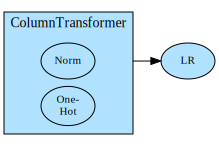

In [5]:
pipeline_trainable = ColumnTransformer(
    transformers=[
        ('num_tfm', Norm(norm='l1'), num_cols),
        ('cat_tfm', OneHot(), cat_cols)]) >> LR()
pipeline_trainable.visualize()

In [6]:
%%time
pipeline_trained = pipeline_trainable.fit(train_X, train_y)

CPU times: user 812 ms, sys: 15.6 ms, total: 828 ms
Wall time: 891 ms


In [7]:
import sklearn.metrics
predictions = pipeline_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, predictions):.1%}')

accuracy 71.2%


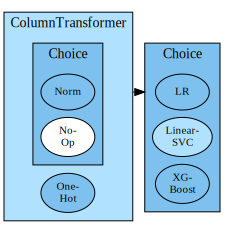

In [8]:
pipeline_planned = make_pipeline(
    ColumnTransformer(transformers=[
        ('num_tfm', Norm | NoOp, num_cols),
        ('cat_tfm', OneHot, cat_cols)]),
    LR | LinearSVC(dual=False)| XGBoost)
pipeline_planned.visualize()

In [9]:
%%time
import sys
from lale.lib.lale import Hyperopt
try:
    pipeline_trained = pipeline_planned.auto_configure(
        train_X, train_y, Hyperopt, cv=3, max_evals=5)
except e:
    print(f'not yet working: {e}', file=sys.stderr)

  0%|                                      | 0/5 [00:00<?, ?it/s, best loss: ?]

  File "/home/hirzel/git/hirzel/lale/lale/operators.py", line 930, in _configure
    helpers.validate_schema(params_all, self.hyperparam_schema())
  File "/home/hirzel/git/hirzel/lale/lale/helpers.py", line 126, in validate_schema
    jsonschema.validate(json_value, schema, jsonschema.Draft4Validator)
  File "/home/hirzel/python3.6venv/lib/python3.6/site-packages/jsonschema/validators.py", line 934, in validate
    raise error
jsonschema.exceptions.ValidationError: None is not of type 'array'

Failed validating 'type' in schema['allOf'][0]['properties']['transformers']:
    {'description': 'Operators or pipelines to be applied to subsets of '
                    'the data.',
     'items': {'description': 'Tuple of (name, transformer, column(s))',
               'items': [{'description': 'Name.', 'type': 'string'},
                         {'anyOf': [{'description': 'Transformer '
                                                    'supporting fit and '
                                 

 20%|██████                        | 1/5 [00:00<00:00,  4.27it/s, best loss: ?]

  File "/home/hirzel/git/hirzel/lale/lale/operators.py", line 930, in _configure
    helpers.validate_schema(params_all, self.hyperparam_schema())
  File "/home/hirzel/git/hirzel/lale/lale/helpers.py", line 126, in validate_schema
    jsonschema.validate(json_value, schema, jsonschema.Draft4Validator)
  File "/home/hirzel/python3.6venv/lib/python3.6/site-packages/jsonschema/validators.py", line 934, in validate
    raise error
jsonschema.exceptions.ValidationError: None is not of type 'array'

Failed validating 'type' in schema['allOf'][0]['properties']['transformers']:
    {'description': 'Operators or pipelines to be applied to subsets of '
                    'the data.',
     'items': {'description': 'Tuple of (name, transformer, column(s))',
               'items': [{'description': 'Name.', 'type': 'string'},
                         {'anyOf': [{'description': 'Transformer '
                                                    'supporting fit and '
                                 

 40%|████████████                  | 2/5 [00:00<00:00,  5.14it/s, best loss: ?]

  File "/home/hirzel/git/hirzel/lale/lale/operators.py", line 930, in _configure
    helpers.validate_schema(params_all, self.hyperparam_schema())
  File "/home/hirzel/git/hirzel/lale/lale/helpers.py", line 126, in validate_schema
    jsonschema.validate(json_value, schema, jsonschema.Draft4Validator)
  File "/home/hirzel/python3.6venv/lib/python3.6/site-packages/jsonschema/validators.py", line 934, in validate
    raise error
jsonschema.exceptions.ValidationError: None is not of type 'array'

Failed validating 'type' in schema['allOf'][0]['properties']['transformers']:
    {'description': 'Operators or pipelines to be applied to subsets of '
                    'the data.',
     'items': {'description': 'Tuple of (name, transformer, column(s))',
               'items': [{'description': 'Name.', 'type': 'string'},
                         {'anyOf': [{'description': 'Transformer '
                                                    'supporting fit and '
                                 

 60%|██████████████████            | 3/5 [00:00<00:00,  5.80it/s, best loss: ?]

  File "/home/hirzel/git/hirzel/lale/lale/operators.py", line 930, in _configure
    helpers.validate_schema(params_all, self.hyperparam_schema())
  File "/home/hirzel/git/hirzel/lale/lale/helpers.py", line 126, in validate_schema
    jsonschema.validate(json_value, schema, jsonschema.Draft4Validator)
  File "/home/hirzel/python3.6venv/lib/python3.6/site-packages/jsonschema/validators.py", line 934, in validate
    raise error
jsonschema.exceptions.ValidationError: None is not of type 'array'

Failed validating 'type' in schema['allOf'][0]['properties']['transformers']:
    {'description': 'Operators or pipelines to be applied to subsets of '
                    'the data.',
     'items': {'description': 'Tuple of (name, transformer, column(s))',
               'items': [{'description': 'Name.', 'type': 'string'},
                         {'anyOf': [{'description': 'Transformer '
                                                    'supporting fit and '
                                 

100%|██████████████████████████████| 5/5 [00:00<00:00,  5.97it/s, best loss: ?]


NameError: name 'e' is not defined